# Calculating the Ellipticity-Ellipticity Galaxy-Mass Correlation Functions

### Spencer Everett, SLAC, 7/16/2015

First import all of the necessary files:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import treecorr
import copy
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa.fits')

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

## Using the module directly:

In [6]:
#d=[1.9,-1.9,-1.9,1.9]
#d = [1.9,1.8,-1.9,-1.8]
B = pangloss.BackgroundCatalog(sigma_e=0.1,field=[0,0,0,0])
B.lens_by_map(K,S)
galaxies = B.galaxies
print B.galaxy_count

36000


In [7]:
# Need this to remove galaxies not contained in the K/S maps:
#galaxies = [B.galaxies[i] for i in range(B.galaxy_count) if not np.isnan(B.galaxies[i]).any()]
#print np.shape(galaxies)

## xi_+ and xi_x Correlation

In [8]:
gg_int = B.calculate_corr(lensed='none')
gg = B.calculate_corr()

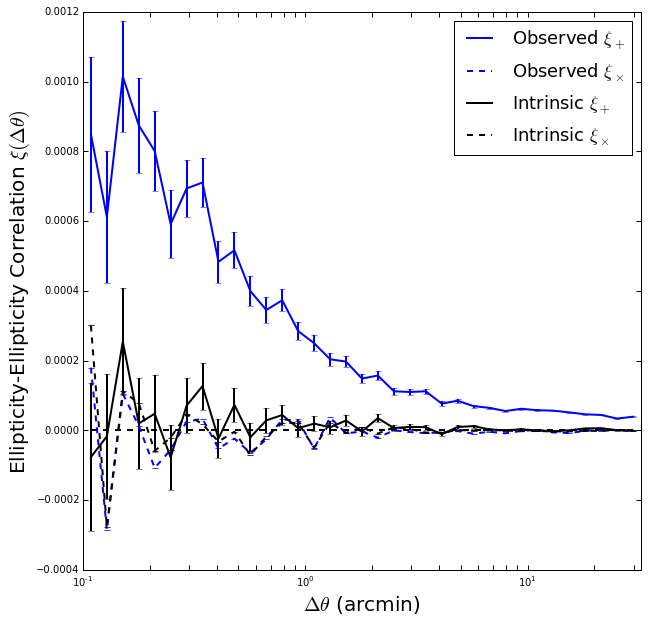

In [9]:
pangloss.plotting.plot_corr(gg,corr_type='gg',corr_comp='plus',lensed='map',color='blue')
pangloss.plotting.plot_corr(gg,corr_type='gg',corr_comp='cross',lensed='map',color='blue')
pangloss.plotting.plot_corr(gg_int,corr_type='gg',corr_comp='plus',lensed='none')
pangloss.plotting.plot_corr(gg_int,corr_type='gg',corr_comp='cross',lensed='none')

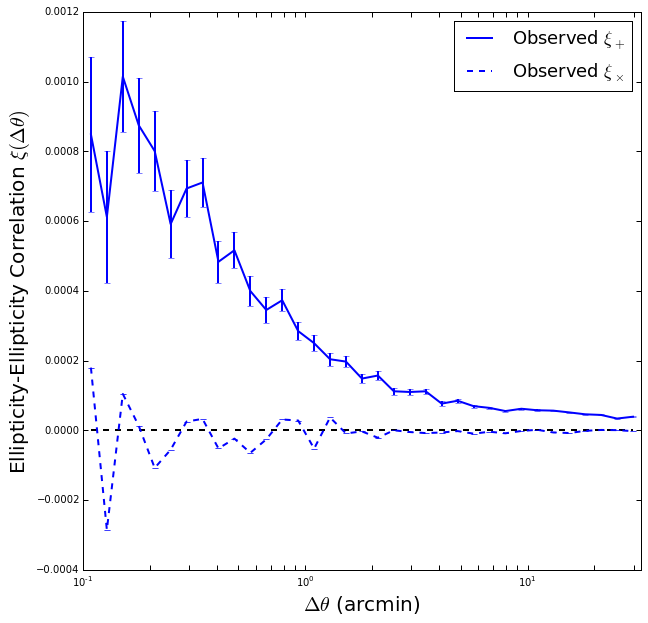

In [10]:
pangloss.plotting.plot_corr(gg,corr_type='gg',corr_comp='plus',lensed='map',color='blue')
pangloss.plotting.plot_corr(gg,corr_type='gg',corr_comp='cross',lensed='map',color='blue')

In [11]:
del B

## Correlation with noise

In [12]:
# Domain size
d=[2.0,1.0,-2.0,-1.0]

B1 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d,field=[0,0,0,0])
B1.lens_by_map(K,S)
B2 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d,field=[0,0,0,0])
B2.lens_by_map(K,S)
B3 = pangloss.BackgroundCatalog(sigma_e=0.2,domain=d,field=[0,0,0,0])
B3.lens_by_map(K,S)
#B2 = copy.deepcopy(B1)
#B3 = copy.deepcopy(B1)

B1.add_noise(M=1.0)
galaxies1 = B1.galaxies

B2.add_noise(M=0.8)
galaxies2 = B2.galaxies

B3.add_noise(M=0.6)
galaxies3 = B3.galaxies

In [15]:
gg1 = B1.calculate_corr(max_sep=5)
gg2 = B2.calculate_corr(max_sep=5)
gg3 = B3.calculate_corr(max_sep=5)

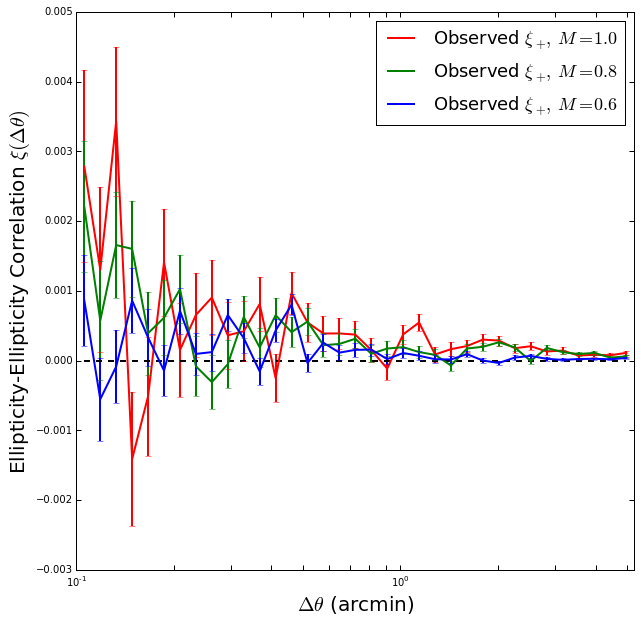

In [16]:
# This doesn't quite work yet! Need to add color plotting options for `plot_corr` and option for M plots
pangloss.plotting.plot_corr(gg1,corr_type='gg',corr_comp='plus',lensed='map',color='red',M=1.0)
pangloss.plotting.plot_corr(gg2,corr_type='gg',corr_comp='plus',lensed='map',color='green',M=0.8)
pangloss.plotting.plot_corr(gg3,corr_type='gg',corr_comp='plus',lensed='map',color='blue',M=0.6)

In [17]:
del B1
del B2
del B3

### Galaxy-Mass:

In [13]:
B = pangloss.BackgroundCatalog(sigma_e=0.0001,field=[0,0,0,0])
B.lens_by_map(K,S)

config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)
print F.galaxy_count

287822


In [14]:
ng_int = B.calculate_corr(corr_type='ng',foreground=F,lensed='none')
ng = B.calculate_corr(corr_type='ng',foreground=F,lensed='map')

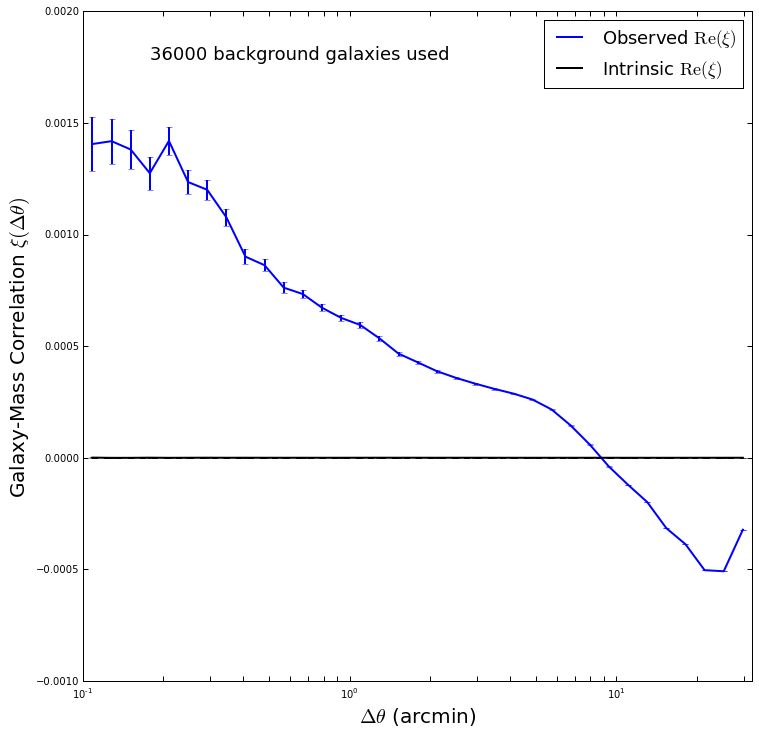

In [15]:
pangloss.plotting.plot_corr(ng,corr_type='ng',corr_comp='real',lensed='map',color='blue',galaxy_count=B.galaxy_count,fig_size=12)
pangloss.plotting.plot_corr(ng_int,corr_type='ng',corr_comp='real',lensed='none',color='black')

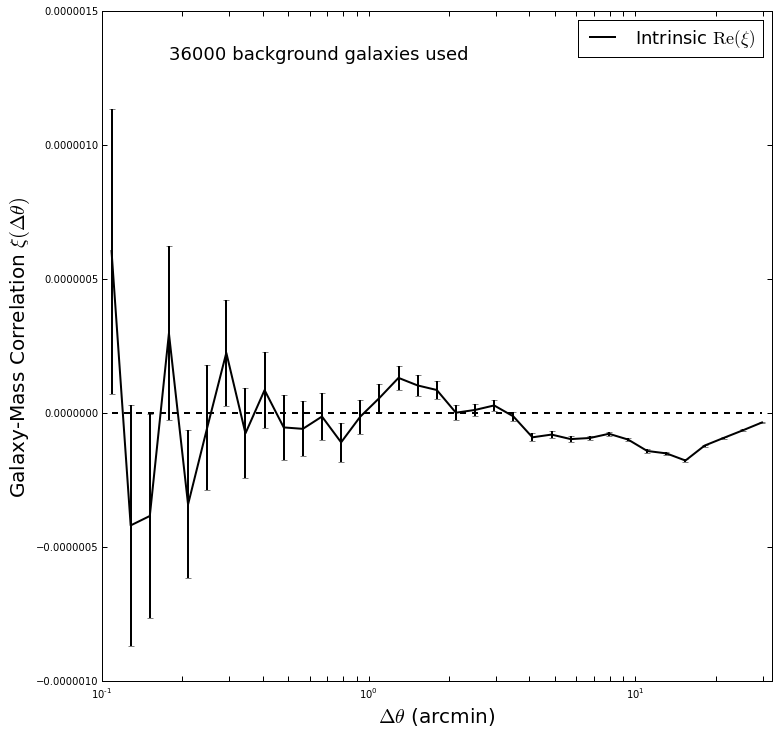

In [18]:
pangloss.plotting.plot_corr(ng_int,corr_type='ng',corr_comp='real',lensed='none',color='black',galaxy_count=B.galaxy_count,fig_size=12)

In [12]:
del B
del F

## Symmetry tests for $\xi_+$ and $\xi_\times^\prime$

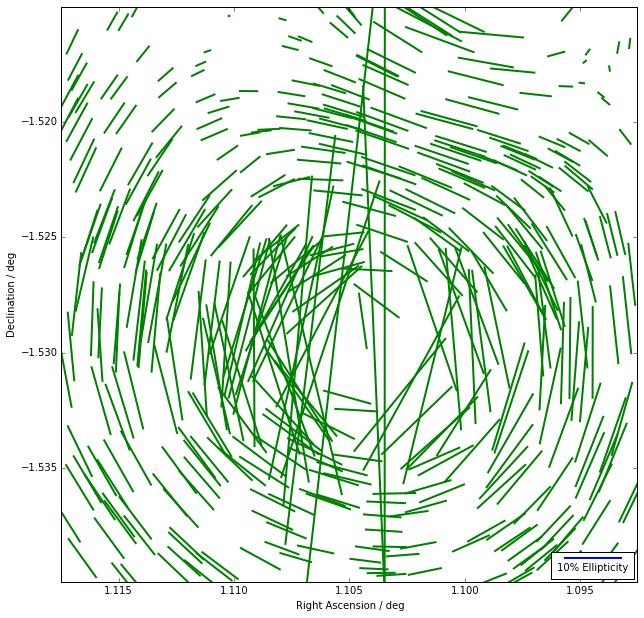

In [12]:
d = [1.1175,1.0925,-1.54,-1.515]
B = pangloss.BackgroundCatalog(N=200,sigma_e=0.0001,domain=d,field=[0,0,0,0])
B.lens_by_map(K,S)



gg = B.calculate_corr()

B.plot(graph='stick',lensed='map')
#print B.galaxies['eMod']
# Rotating all galaxy orientations in place by 45 degrees
B.galaxies['ePhi'] += 10.0
#B.galaxies['eMod'] *= 0.01
B.galaxies['e1'] = B.galaxies['eMod']*np.cos(np.deg2rad(2.0*B.galaxies['ePhi']))
B.galaxies['e2'] = B.galaxies['eMod']*np.sin(np.deg2rad(2.0*B.galaxies['ePhi']))
#print B.galaxies['eMod']

gg45 = B.calculate_corr()

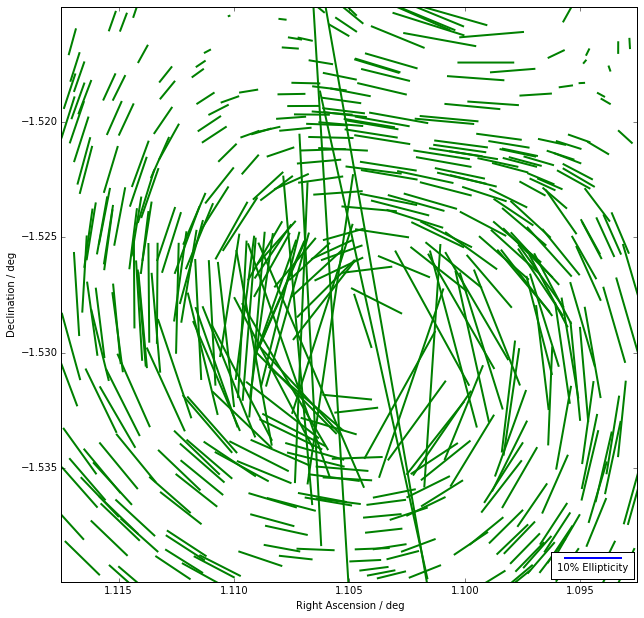

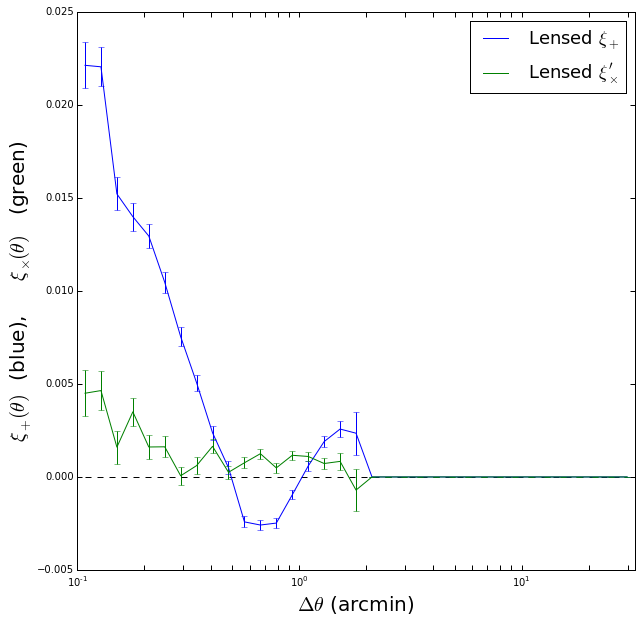

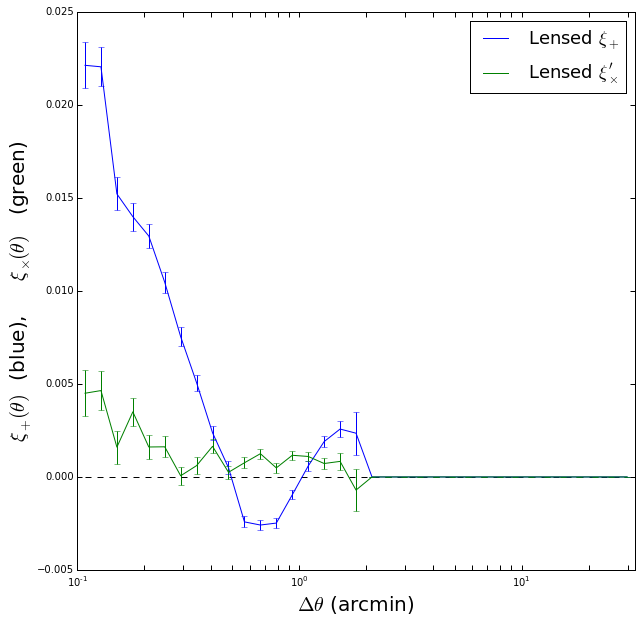

In [13]:
B.plot(graph='stick',lensed='map')
plt.show()
pangloss.plotting.plot_corr(gg)
plt.show()
pangloss.plotting.plot_corr(gg45)